In [1]:
import torch
import torch.nn as nn
import torchvision.datasets as datasets
from torchvision.transforms import ToTensor
import numpy as np


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_data = datasets.MNIST(
    root='data',
    train=True,
    transform=ToTensor(),
    download=False
)

test_data = datasets.MNIST(
    root='data',
    train=False,
    transform=ToTensor()
)

print(train_data)

Dataset MNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()


In [3]:
from torch.utils.data import DataLoader
loaders = {
    'train': torch.utils.data.DataLoader(train_data, batch_size=100, shuffle=True, num_workers=1),
    'test': torch.utils.data.DataLoader(test_data, batch_size=100, shuffle=True, num_workers=1)
}

loaders

{'train': <torch.utils.data.dataloader.DataLoader at 0x7fd3998eedc0>,
 'test': <torch.utils.data.dataloader.DataLoader at 0x7fd3998ee7c0>}

In [4]:
from model import ResNet, Basicblock, Bottleneck
from torch import optim

# model = ResNet(Basicblock, 1, [1, 1, 1, 1], 10)
model = ResNet(Bottleneck, 1, [1, 1, 1, 1], 10)
print(model)
loss_func = nn.CrossEntropyLoss()

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (bottleneck): Sequential(
        (0): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True)
        (6): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (relu): ReLU(inplace=T

In [5]:
optim_sgd = optim.SGD(model.parameters(), lr=0.1, momentum=0.05)
optim = optim_sgd

In [6]:
num_epochs = 5

loss_array = []

def train(num_epochs, model, loaders, optimizer, loss_arr):
    print('* Start Training *...')
    model.train()
    total_steps = len(loaders['train'])
    loss_per_100 = []

    for epoch in range(num_epochs):
        for i, (images, labels) in enumerate(loaders['train']):
            X = images.to(device)
            y = labels.to(device)

            pred = model(X)
            criterion = loss_func(pred, y)

            pred_label = torch.max(pred, 1)[1].data.squeeze() # labels are from 1 to 10, minimum value is 1

            optimizer.zero_grad()
            criterion.backward()
            optimizer.step()

            loss_per_100.append(criterion.detach().numpy())
            if (i + 1) % 100 == 0:
                loss = sum(loss_per_100) / len(loss_per_100)
                loss_arr.append(loss)
                loss_per_100 = []
                print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: [{}/{}]'
                       .format(epoch + 1, num_epochs, i + 1, total_steps, criterion, (pred_label == labels).sum(), len(pred))) # len(pred) == 100
            pass
        pass
    pass


In [7]:
train(num_epochs, model, loaders, optim, loss_array)

* Start Training *...
Epoch [1/5], Step [100/600], Loss: 0.3320, Accuracy: [92/100]
Epoch [1/5], Step [200/600], Loss: 0.1581, Accuracy: [97/100]
Epoch [1/5], Step [300/600], Loss: 0.0425, Accuracy: [98/100]
Epoch [1/5], Step [400/600], Loss: 0.0353, Accuracy: [98/100]
Epoch [1/5], Step [500/600], Loss: 0.0992, Accuracy: [98/100]
Epoch [1/5], Step [600/600], Loss: 0.1661, Accuracy: [95/100]
Epoch [2/5], Step [100/600], Loss: 0.0784, Accuracy: [96/100]
Epoch [2/5], Step [200/600], Loss: 0.0462, Accuracy: [98/100]
Epoch [2/5], Step [300/600], Loss: 0.0889, Accuracy: [98/100]
Epoch [2/5], Step [400/600], Loss: 0.0170, Accuracy: [100/100]
Epoch [2/5], Step [500/600], Loss: 0.0281, Accuracy: [99/100]
Epoch [2/5], Step [600/600], Loss: 0.0050, Accuracy: [100/100]
Epoch [3/5], Step [100/600], Loss: 0.0354, Accuracy: [98/100]
Epoch [3/5], Step [200/600], Loss: 0.0550, Accuracy: [99/100]
Epoch [3/5], Step [300/600], Loss: 0.0606, Accuracy: [99/100]
Epoch [3/5], Step [400/600], Loss: 0.0356, Acc

In [8]:
len(loss_array)

30

<function matplotlib.pyplot.legend(*args, **kwargs)>

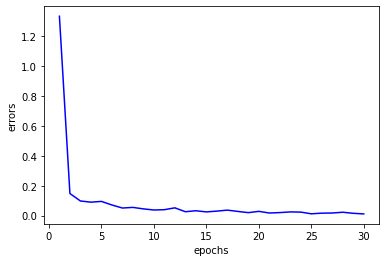

In [9]:
import matplotlib.pyplot as plt

x_range = np.linspace(start=1, stop=30, num=30)
plt.figure()
plt.xlabel('epochs')
plt.ylabel('errors')
plt.plot(x_range, loss_array, color = 'blue')
# plt.plot(x_range, loss_arr_2, color = 'red')
plt.legend